In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [6]:
# read the file
df_train = pd.read_csv("fraudTrain.csv",index_col=0, parse_dates=['trans_date_trans_time','dob'])
# drop redundant column and change types
df_train = df_train.drop("unix_time", axis=1)
df_train['gender'] = df_train['gender'].replace({'F': 1, "M": 0})
#df_train.head()

C:\Users\aberl\AppData\Local\Temp\ipykernel_7164\4168313030.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['gender'] = df_train['gender'].replace({'F': 1, "M": 0})


In [7]:
# show type of data as well as an example
for column in df_train.columns:
    print(f"{column} values are of type : {type(df_train[column][0])}\nexample: {df_train[column][0]}\n")

trans_date_trans_time values are of type : <class 'pandas._libs.tslibs.timestamps.Timestamp'>
example: 2019-01-01 00:00:18

cc_num values are of type : <class 'numpy.int64'>
example: 2703186189652095

merchant values are of type : <class 'str'>
example: fraud_Rippin, Kub and Mann

category values are of type : <class 'str'>
example: misc_net

amt values are of type : <class 'numpy.float64'>
example: 4.97

first values are of type : <class 'str'>
example: Jennifer

last values are of type : <class 'str'>
example: Banks

gender values are of type : <class 'numpy.int64'>
example: 1

street values are of type : <class 'str'>
example: 561 Perry Cove

city values are of type : <class 'str'>
example: Moravian Falls

state values are of type : <class 'str'>
example: NC

zip values are of type : <class 'numpy.int64'>
example: 28654

lat values are of type : <class 'numpy.float64'>
example: 36.0788

long values are of type : <class 'numpy.float64'>
example: -81.1781

city_pop values are of type 

In [8]:
# get size as well as unique values forf each column
print(f"there are {df_train.shape[0]} rows in the dataframe\n")
for column in df_train.columns:
    print(f"in {column} there are {len(df_train[column].unique())} unique entries\n")

there are 1296675 rows in the dataframe

in trans_date_trans_time there are 1274791 unique entries

in cc_num there are 983 unique entries

in merchant there are 693 unique entries

in category there are 14 unique entries

in amt there are 52928 unique entries

in first there are 352 unique entries

in last there are 481 unique entries

in gender there are 2 unique entries

in street there are 983 unique entries

in city there are 894 unique entries

in state there are 51 unique entries

in zip there are 970 unique entries

in lat there are 968 unique entries

in long there are 969 unique entries

in city_pop there are 879 unique entries

in job there are 494 unique entries

in dob there are 968 unique entries

in trans_num there are 1296675 unique entries

in merch_lat there are 1247805 unique entries

in merch_long there are 1275745 unique entries

in is_fraud there are 2 unique entries



In [9]:
def allTransactionCounts(x):
    # get the number of transactions for every day, week, month
    x = x.sort_values('trans_date_trans_time')
    x = x.set_index('trans_date_trans_time')
    x['count_1_day'] = pd.Series(1, index=x.index).rolling('1d').count() - 1
    x['count_7_day'] = pd.Series(1, index=x.index).rolling('7d').count() - 1
    x['count_30_day'] = pd.Series(1, index=x.index).rolling('30d').count() - 1
    return x.reset_index()

In [10]:
def timeDifference(x):
    # Add times since last transaction - time_diff
    x['time_diff'] = x.trans_date_trans_time - x.trans_date_trans_time.shift()
    return x

In [11]:
def preprocess(dataframe: pd.DataFrame):
    df = dataframe.copy()
    
    # Add hour of transaction
    df["tr_hour"] = df["trans_date_trans_time"].dt.hour
    df['hourEnc'] = 0
    df.loc[df.tr_hour < 5, 'hourEnc'] = 1
    df.loc[df.tr_hour > 21, 'hourEnc'] = 1

    # count days and age
    # in days
    df['account_age_days'] = (df['trans_date_trans_time'] - df['dob']).dt.days
    # in years
    df['account_age_years'] = df['account_age_days'] / 365.25
    # group by the years
    df['age_group'] = pd.cut(df['account_age_years'],
                         bins=[0, 18, 25, 35, 50, 65, 90],
                         labels=['<18', '18-25', '26-35', '36-50', '51-65', '65+'])


    # Count transactions in the last 1, 7, and 30 days per cc_num
    df1 = df.groupby('cc_num').apply(allTransactionCounts)
    df1.index = df1.index.droplevel(0)

    # Add time difference between transactions
    df1 = df1.groupby('cc_num').apply(timeDifference)
    df1.index = df1.index.droplevel(0)

    #create the dummies:
    df1 = pd.get_dummies(df1, columns=['category','age_group'], drop_first=True)
    bool_cols = df1.select_dtypes(include='bool').columns
    df1[bool_cols] = df1[bool_cols].astype(int)
    
    #create mean values
    prefered_col = ['cc_num','amt','tr_hour',"hourEnc"]
    df_cc_info = df1[prefered_col].groupby("cc_num").mean()
    df1 = df1.join(df_cc_info,"cc_num",rsuffix="_mean")
    
    for col in df_cc_info.columns:
        oper_col_name = col + "_percent_change"
        df1[oper_col_name] = df1[col] / df1[(col + "_mean")] - 1
    
    
    # get numeric columns
    numeric_cols = []
    for column in df1.columns:
        if df1[column].dtype in [np.int32,np.int64, np.float64]:
            numeric_cols.append(column)
    print(numeric_cols)
    return df1[numeric_cols]

<Axes: >

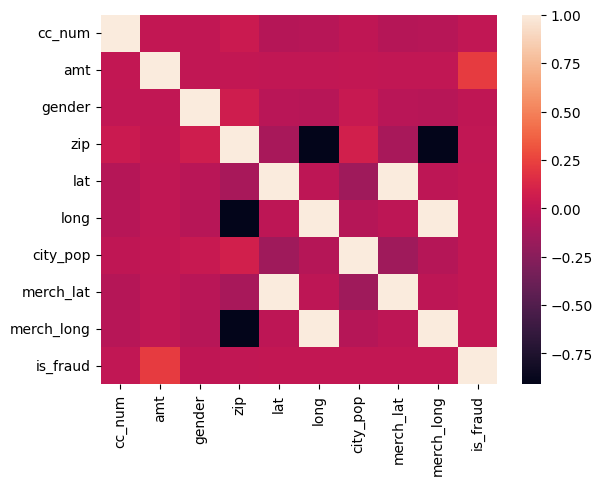

In [12]:
#get basic correlation with numerical data
numeric_cols = []
for column in df_train.columns:
    if df_train[column].dtype in [np.int32,np.int64, np.float64]:
        numeric_cols.append(column)
        
corr_train = df_train[numeric_cols].corr()
sns.heatmap(corr_train)

In [13]:
df_train_final = preprocess(df_train)
df_train_final.head()

C:\Users\aberl\AppData\Local\Temp\ipykernel_7164\2278327161.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1 = df.groupby('cc_num').apply(allTransactionCounts)
C:\Users\aberl\AppData\Local\Temp\ipykernel_7164\2278327161.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1 = df1.groupby('cc_num').apply(timeDifference)


['cc_num', 'amt', 'gender', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'is_fraud', 'tr_hour', 'hourEnc', 'account_age_days', 'account_age_years', 'count_1_day', 'count_7_day', 'count_30_day', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel', 'age_group_18-25', 'age_group_26-35', 'age_group_36-50', 'age_group_51-65', 'age_group_65+', 'amt_mean', 'tr_hour_mean', 'hourEnc_mean', 'amt_percent_change', 'tr_hour_percent_change', 'hourEnc_percent_change']


,cc_num,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,...,age_group_26-35,age_group_36-50,age_group_51-65,age_group_65+,amt_mean,tr_hour_mean,hourEnc_mean,amt_percent_change,tr_hour_percent_change,hourEnc_percent_change
0,60416207185,7.27,1,82514,43.0048,-108.8964,1645,43.974711,-109.741904,0,...,1,0,0,0,56.023366,13.687747,0.236495,-0.870233,-0.123303,-1.0
1,60416207185,52.94,1,82514,43.0048,-108.8964,1645,42.018766,-109.044172,0,...,1,0,0,0,56.023366,13.687747,0.236495,-0.055037,-0.415536,-1.0
2,60416207185,82.08,1,82514,43.0048,-108.8964,1645,42.961335,-109.157564,0,...,1,0,0,0,56.023366,13.687747,0.236495,0.465103,-0.415536,-1.0
3,60416207185,34.79,1,82514,43.0048,-108.8964,1645,42.228227,-108.747683,0,...,1,0,0,0,56.023366,13.687747,0.236495,-0.379009,-0.123303,-1.0
4,60416207185,27.18,1,82514,43.0048,-108.8964,1645,43.321745,-108.091143,0,...,1,0,0,0,56.023366,13.687747,0.236495,-0.514845,-0.050245,-1.0


<Axes: >

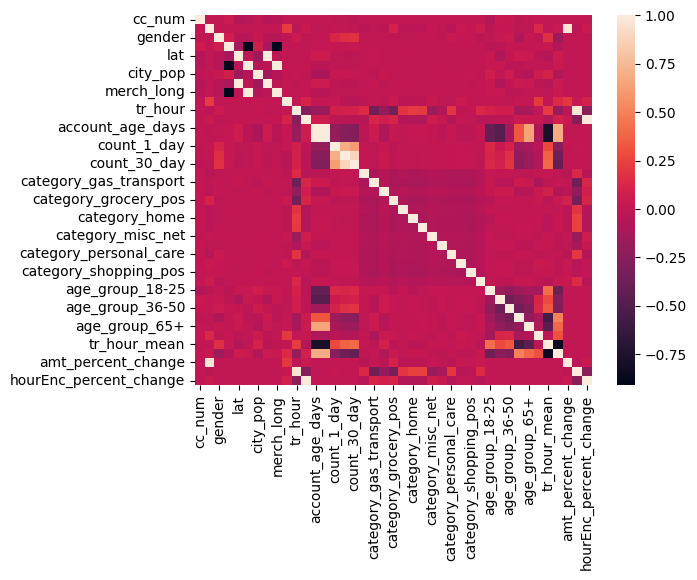

In [14]:
# get correlation of numerical values
corr_train = df_train_final.corr()
sns.heatmap(corr_train)


In [15]:
corr_train['is_fraud'].abs().sort_values(ascending=False)

is_fraud                   1.000000
amt                        0.219404
amt_mean                   0.209960
amt_percent_change         0.196145
hourEnc_mean               0.136832
hourEnc                    0.101077
hourEnc_percent_change     0.087967
count_30_day               0.046523
category_shopping_net      0.044261
count_7_day                0.036301
category_grocery_pos       0.035558
category_misc_net          0.025886
tr_hour_percent_change     0.018599
category_home              0.017848
category_food_dining       0.015025
category_kids_pets         0.014967
category_health_fitness    0.014885
tr_hour                    0.013799
account_age_years          0.012270
account_age_days           0.012270
category_personal_care     0.012167
age_group_36-50            0.011416
age_group_51-65            0.010788
category_misc_pos          0.008937
count_1_day                0.008638
age_group_65+              0.008624
gender                     0.007642
category_grocery_net       0

### get test data:

In [16]:
df_test = pd.read_csv("fraudTest.csv",index_col=0, parse_dates=['trans_date_trans_time','dob'])
df_test = df_test.drop("unix_time", axis=1)
df_test['gender'] = df_test['gender'].replace({'F': 1, "M": 0})
df_test = preprocess(df_test)

C:\Users\aberl\AppData\Local\Temp\ipykernel_7164\4018789693.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['gender'] = df_test['gender'].replace({'F': 1, "M": 0})
C:\Users\aberl\AppData\Local\Temp\ipykernel_7164\2278327161.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1 = df.groupby('cc_num').apply(allTransactionCounts)
C:\Users\aberl\AppData\Local\Temp\ipykernel_7164\2278327161.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the gro

['cc_num', 'amt', 'gender', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'is_fraud', 'tr_hour', 'hourEnc', 'account_age_days', 'account_age_years', 'count_1_day', 'count_7_day', 'count_30_day', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel', 'age_group_18-25', 'age_group_26-35', 'age_group_36-50', 'age_group_51-65', 'age_group_65+', 'amt_mean', 'tr_hour_mean', 'hourEnc_mean', 'amt_percent_change', 'tr_hour_percent_change', 'hourEnc_percent_change']


## Importing the AI

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve,classification_report,auc, ConfusionMatrixDisplay,roc_auc_score,roc_curve

In [18]:
df_test.columns

Index(['cc_num', 'amt', 'gender', 'zip', 'lat', 'long', 'city_pop',
       'merch_lat', 'merch_long', 'is_fraud', 'tr_hour', 'hourEnc',
       'account_age_days', 'account_age_years', 'count_1_day', 'count_7_day',
       'count_30_day', 'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'age_group_18-25', 'age_group_26-35', 'age_group_36-50',
       'age_group_51-65', 'age_group_65+', 'amt_mean', 'tr_hour_mean',
       'hourEnc_mean', 'amt_percent_change', 'tr_hour_percent_change',
       'hourEnc_percent_change'],
      dtype='object')

In [19]:
labels = ['cc_num', 'amt', 'gender', 'zip', 'lat', 'long', 'city_pop',
       'merch_lat', 'merch_long', 'tr_hour', 'hourEnc',
       'account_age_days', 'account_age_years', 'count_1_day', 'count_7_day',
       'count_30_day', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'age_group_18-25',
       'age_group_26-35', 'age_group_36-50', 'age_group_51-65',
       'age_group_65+', 'amt_mean', 'tr_hour_mean',
       'hourEnc_mean', 'amt_percent_change', 'tr_hour_percent_change', 'hourEnc_percent_change']
goal = ['is_fraud']
# get a data frame for each X and Y
df_train_x = df_train_final[labels]
df_train_y = df_train_final[goal]
df_test_x = df_test[labels]
df_test_y = df_test[goal]

In [20]:
# instanciate AI
Mesmer = LogisticRegression(max_iter=1000,class_weight='balanced') #class weight to penalise way more minority classes
# train AI
Mesmer.fit(df_train_x,df_train_y["is_fraud"])
# get predictions from the AI
df_pred_y = Mesmer.predict(df_test_x)
df_pred_proba_y = Mesmer.predict_proba(df_test_x)

In [21]:
print(classification_report(df_test_y, df_pred_y, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719



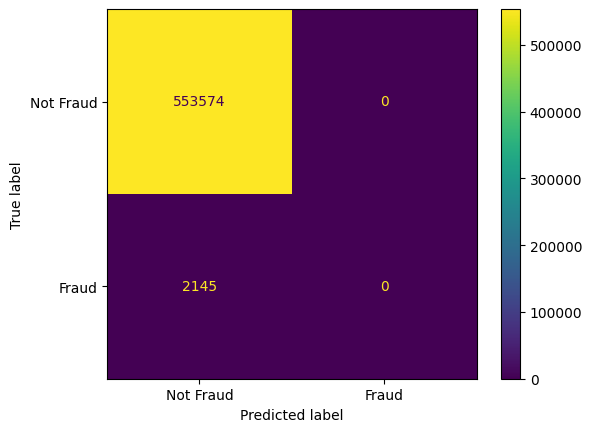

In [22]:
cm = confusion_matrix(df_test_y["is_fraud"], df_pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot()
plt.show()

In [23]:
roc_auc = roc_auc_score(df_test_y["is_fraud"], df_pred_proba_y[:, 1])
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.5314086754566256


### Random Forest:

In [24]:
from sklearn.ensemble import RandomForestClassifier

Mesmer = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,           # Limits tree depth
    max_features='sqrt',    # Only consider √features per split
    class_weight='balanced',
    n_jobs=-1,              # Use all available CPU cores
    random_state=42
)
Mesmer.fit(df_train_x, df_train_y["is_fraud"])


RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=42)

In [25]:
# get predictions from the AI
df_pred_y = Mesmer.predict(df_test_x)

In [26]:
print(classification_report(df_test_y, df_pred_y, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    553574
           1       0.19      0.92      0.32      2145

    accuracy                           0.98    555719
   macro avg       0.60      0.95      0.66    555719
weighted avg       1.00      0.98      0.99    555719



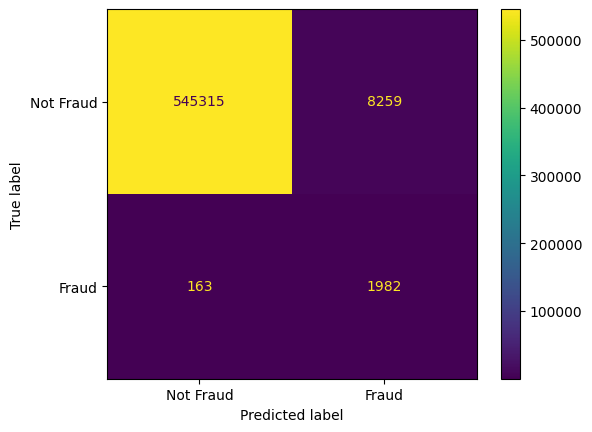

In [27]:
cm = confusion_matrix(df_test_y["is_fraud"], df_pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot()
plt.show()

In [28]:
df_pred_proba_y = Mesmer.predict_proba(df_test_x)
roc_auc = roc_auc_score(df_test_y["is_fraud"], df_pred_proba_y[:, 1])
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9889573751236329


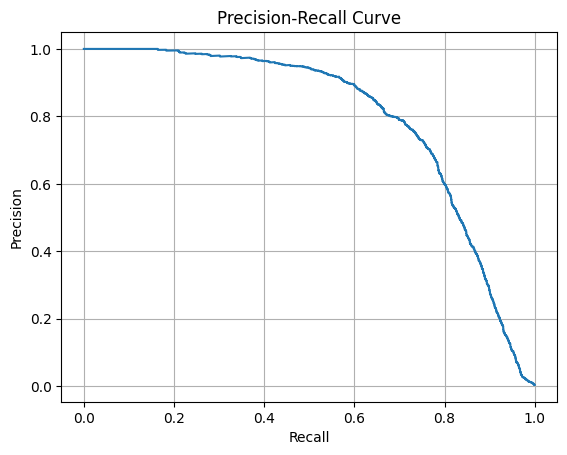

In [29]:
precision, recall, thresholds = precision_recall_curve(df_test_y["is_fraud"], df_pred_proba_y[:,1])

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

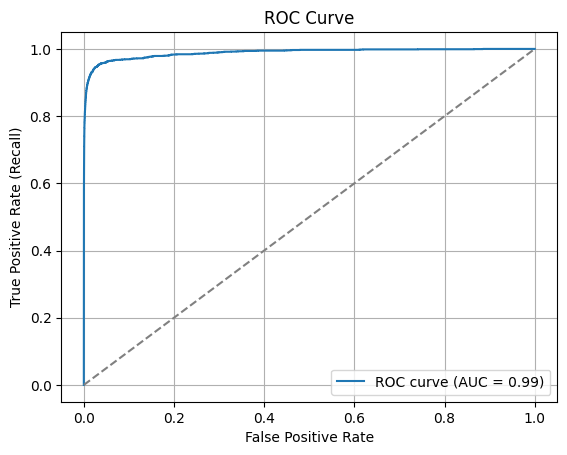

In [30]:
y_probs = Mesmer.predict_proba(df_test_x)[:, 1]
fpr, tpr, thresholds = roc_curve(df_test_y["is_fraud"], y_probs)
roc_auc = roc_auc_score(df_test_y["is_fraud"], y_probs)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

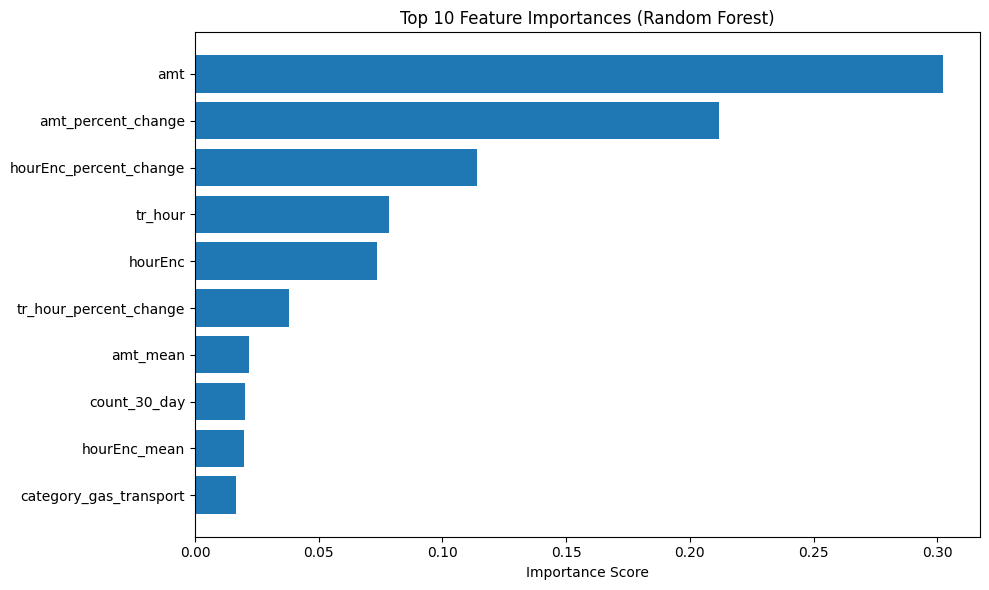

In [31]:
feature_names = df_train_x.columns
importances = Mesmer.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### XG Boost

In [32]:
from xgboost import XGBClassifier

Mesmer = XGBClassifier(
    eval_metric='logloss', 
    random_state=42
)
Mesmer.fit(df_train_x, df_train_y["is_fraud"])

# get predictions from the AI
df_pred_y = Mesmer.predict(df_test_x)
df_pred_proba_y = Mesmer.predict_proba(df_test_x)[:, 1]

print("=== XGBoost ===")
print(classification_report(df_test_y, df_pred_y))
print("AUC:", roc_auc_score(df_test_y, df_pred_proba_y))

=== XGBoost ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.80      0.76      0.78      2145

    accuracy                           1.00    555719
   macro avg       0.90      0.88      0.89    555719
weighted avg       1.00      1.00      1.00    555719

AUC: 0.9801364168653817
